In [3]:
import warnings
# 경고 메시지를 무시하고 숨기거나
warnings.filterwarnings(action='ignore')

#결과 여러개 뜨게 하기
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [4]:
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import scipy.stats as stats
from cvxopt import matrix
from cvxopt.solvers import qp

import arch

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss


## Data Preprocessing for security_selection
Extract only the top 10 cumulative returns over 10 years

In [13]:
#dataframe으로 변환
df_stock_data = pd.read_excel('../Database/dataset.xlsx',index_col=0)
print(df_stock_data)

                    A005930 A000660   A005490 A005380 A006400 A000270 A012330   
Symbol                                                                          
Symbol Name            삼성전자  SK하이닉스  POSCO홀딩스     현대차   삼성SDI      기아   현대모비스  \
1999-12-28 00:00:00    5320  473074    125000   18000   47200    7100    5750   
2000-01-31 00:00:00    5580  518222    133000   17100   44500    6720    6230   
2000-02-29 00:00:00    5120  351370    111500   12050   32900    4470    4070   
2000-03-31 00:00:00    6700  482889    106500   13400   41000    5000    4070   
...                     ...     ...       ...     ...     ...     ...     ...   
2020-08-31 00:00:00   54000   75100    184500  176500  452500   42450  224000   
2020-09-29 00:00:00   58200   84000    196000  178500  433500   46900  230000   
2020-10-30 00:00:00   56600   79900    208000  164500  442000   50500  225500   
2020-11-30 00:00:00   66700   97500    234000  181500  533000   57800  244000   
2020-12-30 00:00:00   81000 

In [12]:

df_train = df_stock_data.iloc[1:122,:]
#Monthly Return (2000~2009)
df_profit = df_train.pct_change()

#Top cumulative returns
df_profit_acc = (1+df_profit).cumprod()-1
select_stocks_value = df_profit_acc.iloc[-1,:].sort_values(ascending = False)
select_stocks = list(select_stocks_value[:25].index)
print(select_stocks)

['A023790', 'A012330', 'A006730', 'A005690', 'A011810', 'A025950', 'A024950', 'A001840', 'A010060', 'A033920', 'A026960', 'A028050', 'A006360', 'A006040', 'A004020', 'A001940', 'A002840', 'A008930', 'A005090', 'A025890', 'A021240', 'A019170', 'A005160', 'A005300', 'A018310']


        Symbol Name  acc_return
A023790        동일철강   37.320000
A012330       현대모비스   28.739130
A006730       서부T&D   28.114007
A005690         파미셀   26.242647
A011810         STX   24.596509
A025950        동신건설   20.744472
A024950      삼천리자전거   20.428571
A001840        이화공영   19.995935
A010060      OCI홀딩스   18.422036
A033920          무학   14.977528
A026960          동서   14.555380
A028050     삼성엔지니어링   14.541320
A006360        GS건설   13.863704
A006040        동원산업   13.622057
A004020        현대제철   13.297521
A001940    KISCO홀딩스   13.235241
A002840        미원상사   13.028800
A008930      한미사이언스   12.623068
A005090      SGC에너지   12.348485
A025890        한국주강   12.282123
A021240         코웨이   12.096862
A019170        신풍제약   11.674157
A005160        동국산업   11.059585
A005300        롯데칠성   11.042280
A018310       삼목에스폼   11.022082


<BarContainer object of 25 artists>

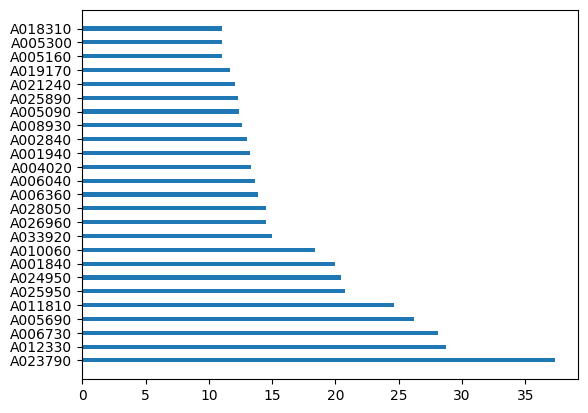

In [16]:
value_select_stock = pd.concat([df_stock_data.loc['Symbol Name',select_stocks],select_stocks_value[select_stocks]],axis=1)
value_select_stock.columns = ['Symbol Name','acc_return']
print(value_select_stock)
plt.barh(value_select_stock.index.to_list(),value_select_stock['acc_return'].to_list(),height=0.3)

In [17]:
def calculate_value(return_rate):
    acc_return_rate = (1+return_rate)
    initial_price = 100
    acc_return_rate.iloc[0,:] = acc_return_rate.iloc[0,:] * initial_price
    acc_return_rate = acc_return_rate.cumprod()

    return acc_return_rate


In [18]:
def cal_sharpe(return_rate):
    return_rate = pd.DataFrame(return_rate)
    acc_return_rate = calculate_value(return_rate)
    initial_price = 100
    last_price = acc_return_rate.iloc[-1,:][0]

    annualized_return = np.power(last_price/initial_price,1/10)-1
    annualized_std = return_rate.std()[0]*np.sqrt(12)

    sharp = annualized_return/annualized_std
    
    return sharp

In [19]:
def cal_sortino(return_rate):
    return_rate = pd.DataFrame(return_rate)
    acc_return_rate = calculate_value(return_rate)
    initial_price = 100
    last_price = acc_return_rate.iloc[-1,:][0]

    minus_return = return_rate[return_rate<0]
    annualized_return = np.power(last_price/initial_price,1/10)-1
    annualized_downside_std = minus_return.std()[0]*np.sqrt(12)
    sortino = annualized_return/annualized_downside_std
    
    return sortino
   

In [20]:
# 각 종목별 10년치 sharp지수를 보고 판단
df_profit = df_profit.dropna()
df_profit.loc['sharp'] = df_profit.apply(cal_sharpe,axis=0)
select_stocks = list(df_profit.loc['sharp'].sort_values(ascending=False)[:25].index)

A002840        미원상사
A026960          동서
A012330       현대모비스
A000100        유한양행
A008930      한미사이언스
A005300        롯데칠성
A005090      SGC에너지
A001340        백광산업
A006360        GS건설
A004170         신세계
A028050     삼성엔지니어링
A002790        아모레G
A016800         퍼시스
A004990        롯데지주
A001940    KISCO홀딩스
A007310         오뚜기
A009970     영원무역홀딩스
A021240         코웨이
A009680         모토닉
A006730       서부T&D
A000240      한국앤컴퍼니
A000810        삼성화재
A010060      OCI홀딩스
A003650        미창석유
A001800      오리온홀딩스
Name: Symbol Name, dtype: object

<BarContainer object of 25 artists>

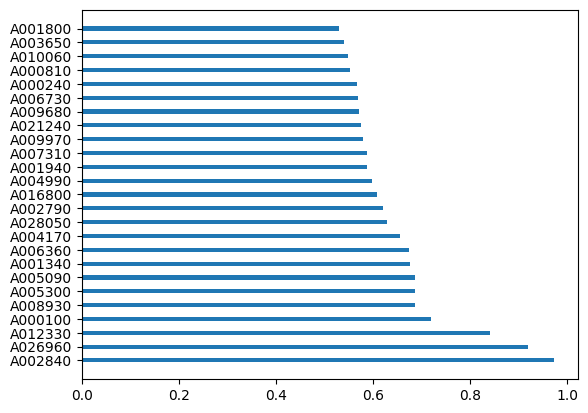

In [21]:
value_select_stock = pd.DataFrame(pd.concat([df_stock_data.loc['Symbol Name',select_stocks],df_profit.loc['sharp'][select_stocks]],axis=1))
df_stock_data.loc['Symbol Name',select_stocks]
plt.barh(value_select_stock.index.to_list(),value_select_stock['sharp'].to_list(),height=0.3)

In [ ]:
# 각 종목별 10년치 sortino지수 보고 판단
df_profit = df_profit.dropna()
df_profit.loc['sortino'] = df_profit.apply(cal_sortino,axis=0)
select_stocks = list(df_profit.loc['sortino'].sort_values(ascending=False)[:25].index)


In [ ]:
value_select_stock = pd.DataFrame(pd.concat([df_stock_data.loc['Symbol Name',select_stocks],df_profit.loc['sortino'][select_stocks]],axis=1))
plt.barh(value_select_stock.index.to_list(),value_select_stock['sortino'].to_list(),height=0.3)


In [ ]:
# 랜덤으로 짜는 방법
import random
columns = list(df_profit.columns)
select_stocks = random.sample(columns, 25)

### 1. 예상 수익률과 종목 변동성을 각각 arima와 garch로 구함
### 2. makowitz 공식에 대입해서 weight값 구함
### 3. weight값을 토대로 월별 수익률을 기록 이후 sliding window 방식으로 백테스팅

In [ ]:
def predict_with_arima(stock_rate):
    model = ARIMA(stock_rate.diff(), order=(1,0,1)).fit()
    forcast = model.forecast(steps=1)
    return np.array(forcast)[0] + stock_rate[-1]

In [ ]:
def predict_with_garch(stock_rate):
    model = arch.arch_model(stock_rate,vol='GARCH', p=1,q=1).fit()
    forcast = model.forecast(horizon=1)
    return np.sqrt(forcast.variance[-1:].values[0][0])
    

In [ ]:
# #저장한걸 불러오기
# stock_list = pd.read_excel('num_is_25_r_min_001_random2.xlsx')
# 
# select_stocks = list(stock_list.columns)
# select_stocks

In [ ]:
def calculate_return_rate(select_stocks, r_min):    
    df_month_profit = df_stock_data.iloc[1:,:][select_stocks].pct_change().dropna()
    num = len(select_stocks)
    return_rate = []

    index = list(df_month_profit.index)[120:len(df_month_profit)]
    #walk forward analysis
    #Total number of data: 252 (0~251), tested 132 times
    for i in range(0,len(df_month_profit)-120):
        security_selection_train_return = df_month_profit.iloc[i:120+i,:]
        security_selection_test_return = df_month_profit.iloc[120+i,:]
    
        corr = security_selection_train_return.corr().to_numpy()
        mean_list = []
        sigma_list = []
        for j in range(num):
            target = security_selection_train_return.iloc[:,j]
            forcast_return_result = predict_with_arima(target)
            mean_list.append(forcast_return_result)
    
            forcast_vot_result = predict_with_garch(target)
            sigma_list.append(forcast_vot_result)
    
        weight = calculate_weight(mean_list,sigma_list,corr,num,r_min)
        weight = np.transpose(weight)
        x = matrix(security_selection_test_return)
        month_return = weight @ x
        return_rate.append(month_return[0][0])
    
    return_rate = pd.DataFrame(return_rate)
    return_rate.index = index
    
    return df_month_profit,return_rate

In [ ]:
def calculate_weight(mean_list,sigma_list,corr,num,r_min):
    #공분산 행렬 만들기 sigma @ T(sigma) * corr   
    Mean = matrix([mean_list])
    sigma = matrix([sigma_list])
    sigma = sigma@np.transpose(sigma)
    cov = matrix(sigma*corr)

    G = matrix(np.concatenate((-np.transpose(Mean), -np.identity(num)), 0))
    h = matrix(np.concatenate((-np.ones((1,1))*r_min, np.zeros((num,1))), 0))
    A = matrix(1.0, (1,num))
    b = matrix(1.0)
    q = matrix(np.zeros((num,1)))
    sol = qp(cov, q, G, h, A ,b)
    return sol['x']

In [ ]:
return_rate = calculate_return_rate(select_stocks,0.01)

In [ ]:
df_month_profit, return_rate = return_rate

In [ ]:
#종목 내보내기
# df_month_profit.to_excel('best.xlsx')

In [ ]:
# 누적수익률
df_profit_accumulate = (1+return_rate).cumprod()-1
df_profit_accumulate

In [ ]:
#코스피 표시
df_kospi_data = pd.read_excel('./kospi.xlsx',index_col=0)
df_kospi_data_pct_return = df_kospi_data.pct_change().dropna()
df_kospi_data_accumulate_return = (1+df_kospi_data_pct_return).cumprod()-1
df_kospi_data_accumulate_return.index = df_profit_accumulate.index

In [ ]:
month_index = pd.date_range(start = '2009-12-01',end = '2021-01-01',freq='M')
df_kospi_data.index = month_index

In [ ]:
def calculate_value(return_rate):
    acc_return_rate = (1+return_rate)
    initial_price = 100
    acc_return_rate.iloc[0,:] = acc_return_rate.iloc[0,:] * initial_price
    acc_return_rate = acc_return_rate.cumprod()
    
    return acc_return_rate
    

In [ ]:
def cal_sharpe(return_rate):
    acc_return_rate = calculate_value(return_rate)
    initial_price = 100
    last_price = acc_return_rate.iloc[-1,:][0]
    
    annualized_return = np.power(last_price/initial_price,1/11)-1
    annualized_std = return_rate.std()*np.sqrt(12)

    sharp = annualized_return / annualized_std
    print(f'annualized_return : {annualized_return}\n'
          f'annualized_std : {annualized_std[0]}\n'
          f'sharp: {sharp[0]}')
    
    

In [ ]:
def cal_sortino(return_rate):
    acc_return_rate = calculate_value(return_rate)
    initial_price = 100
    last_price = acc_return_rate.iloc[-1,:][0]
    
    minus_return = return_rate[return_rate<0]
    annualized_return = np.power(last_price/initial_price,1/11)-1
    annualized_downside_std = minus_return.std()*np.sqrt(12)
    sortino = annualized_return/annualized_downside_std
    
    print(f'annualized_return : {annualized_return}\n'
          f'annualized_downside_std : {annualized_downside_std[0]}\n'
          f'sortino: {sortino[0]}')

In [ ]:
cal_sharpe(return_rate)

In [ ]:
cal_sharpe(df_kospi_data_pct_return)

In [ ]:
cal_sortino(return_rate)

In [ ]:
cal_sortino(df_kospi_data_pct_return)

In [ ]:
df_kospi_data_pct_return.index = return_rate.index

plt.plot(calculate_value(df_kospi_data_pct_return), label='kospi')
plt.plot(calculate_value(return_rate), label='portfolio')
plt.xlabel('year')
plt.ylabel('acc_value')
plt.legend()


In [ ]:
(1+return_rate).cumprod()-1